# Hypothesis Tests for State/County and Population/Area Relationships

This notebook contains the calculations for compaing the relationships between vaccine location numbers per person and square mile when compared to the estimated vaccination rate for states/counties over multiple metrics

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

df = pd.read_csv("data/data_finalized.csv")

C:\Users\npear\AppData\Local\Temp\ipykernel_7604\1700513824.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import pearsonr, spearmanr


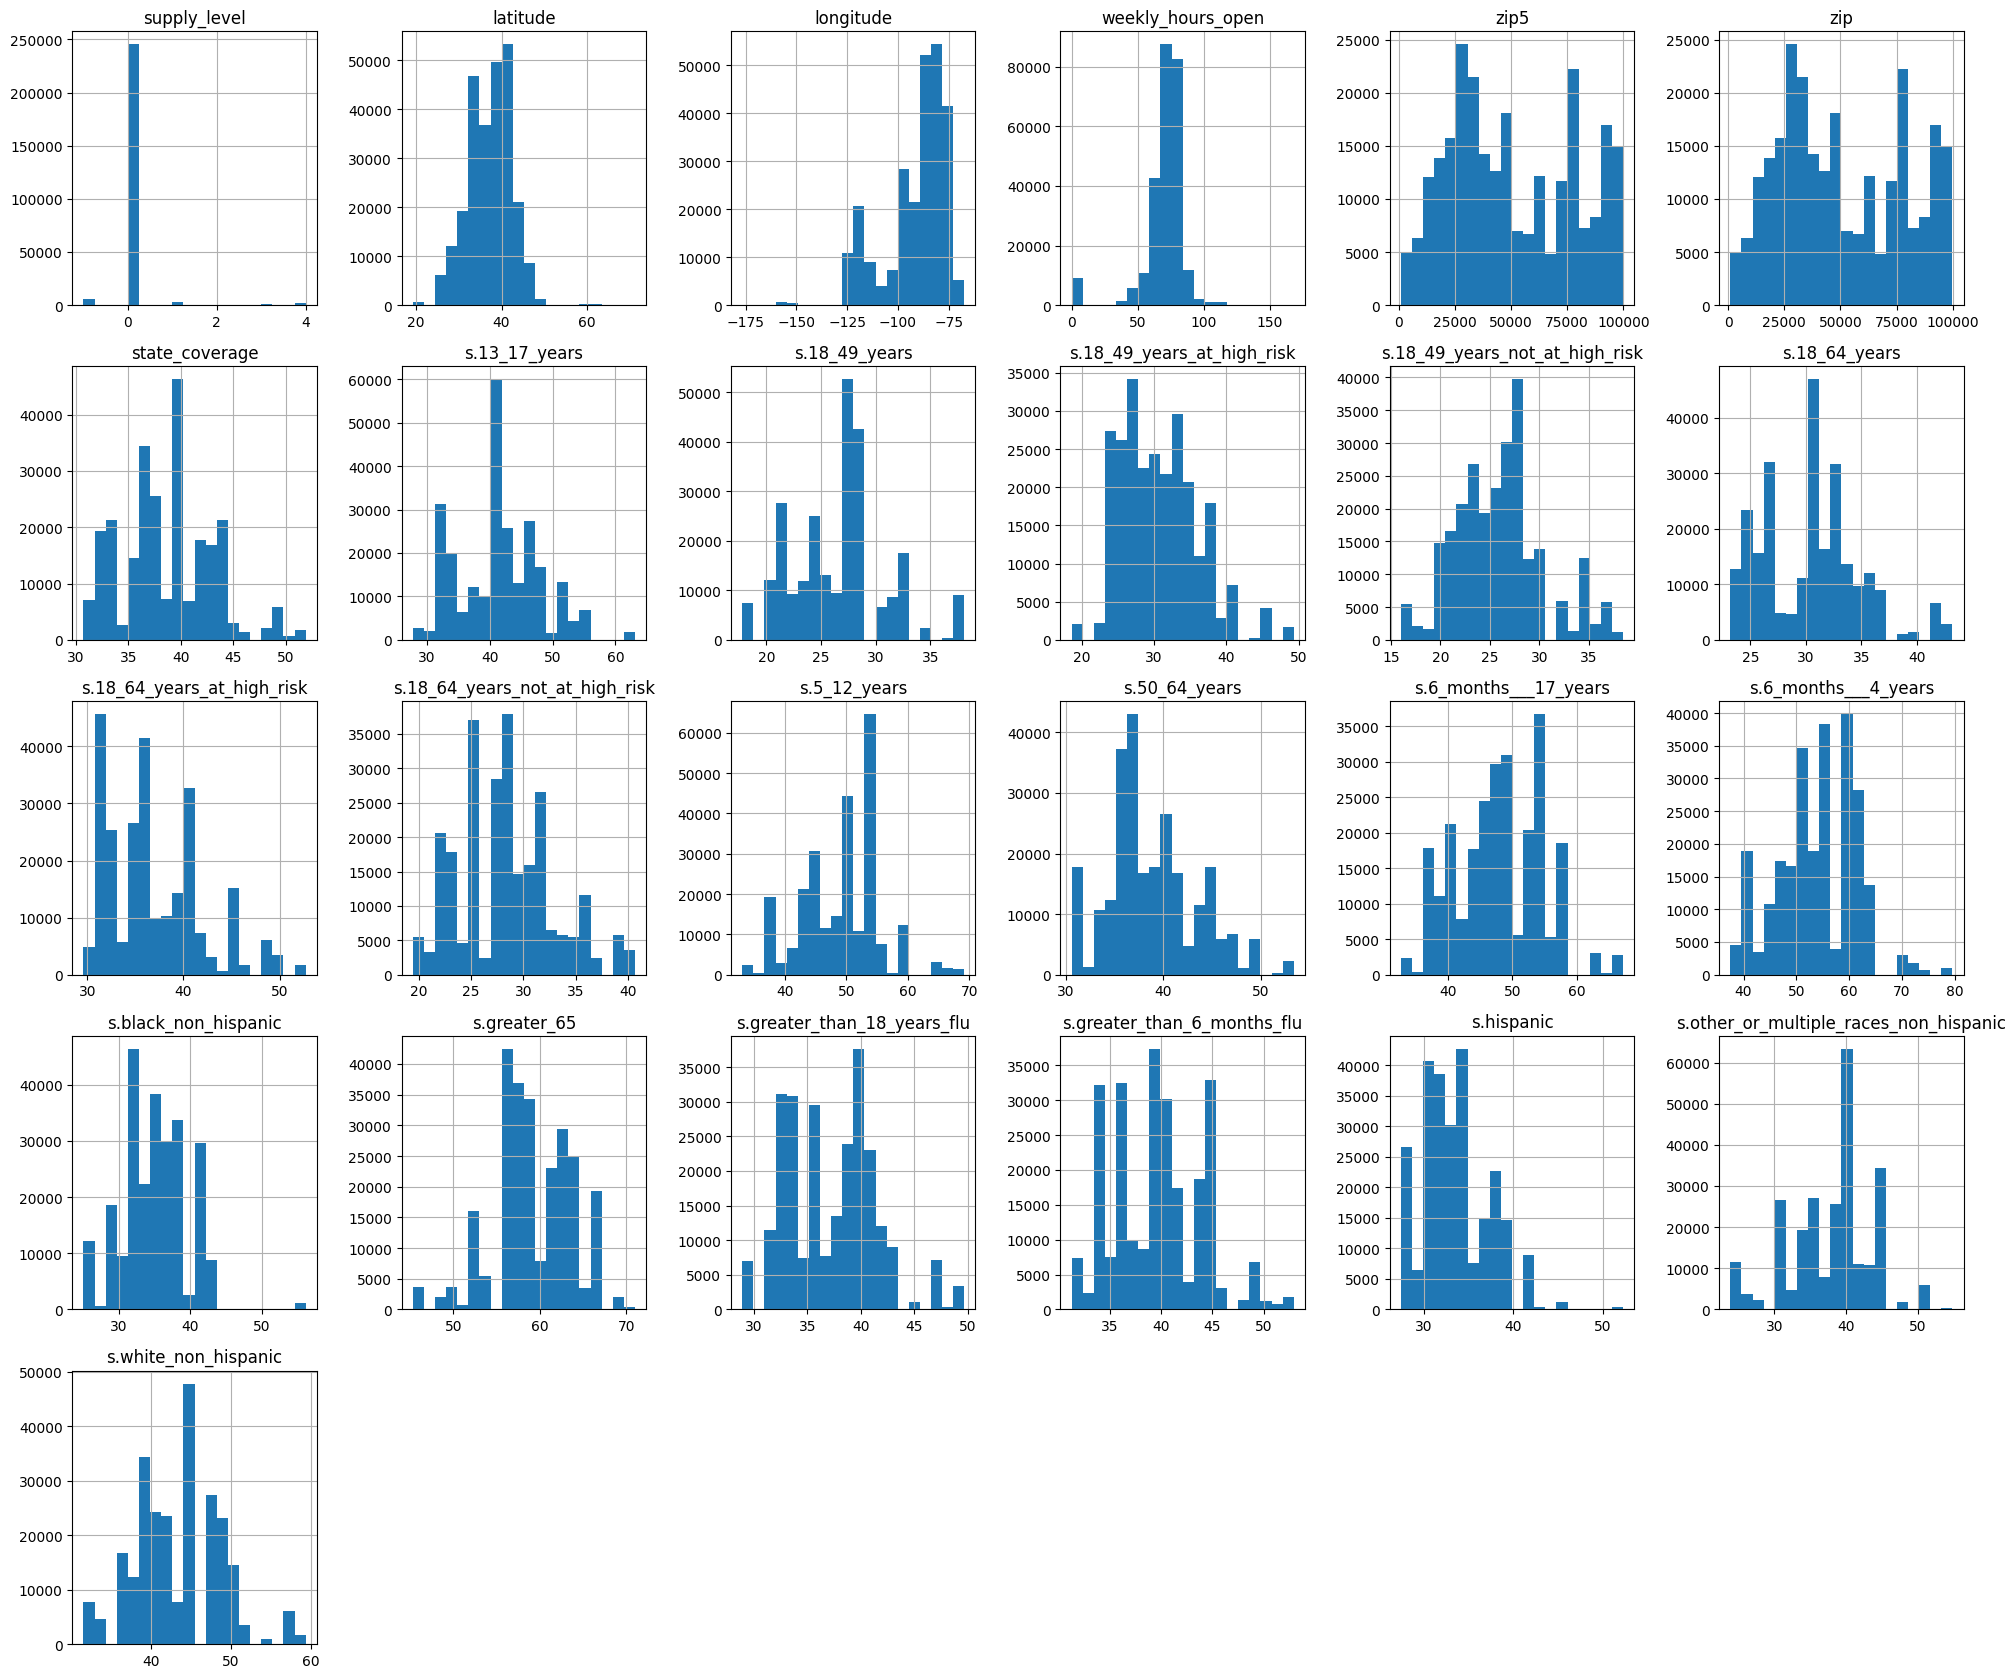

In [2]:
# Set of histograms for all numeric columns
numeric_cols = df.select_dtypes(include='number').columns
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    df[col].hist(ax=axes[i], bins=20)
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

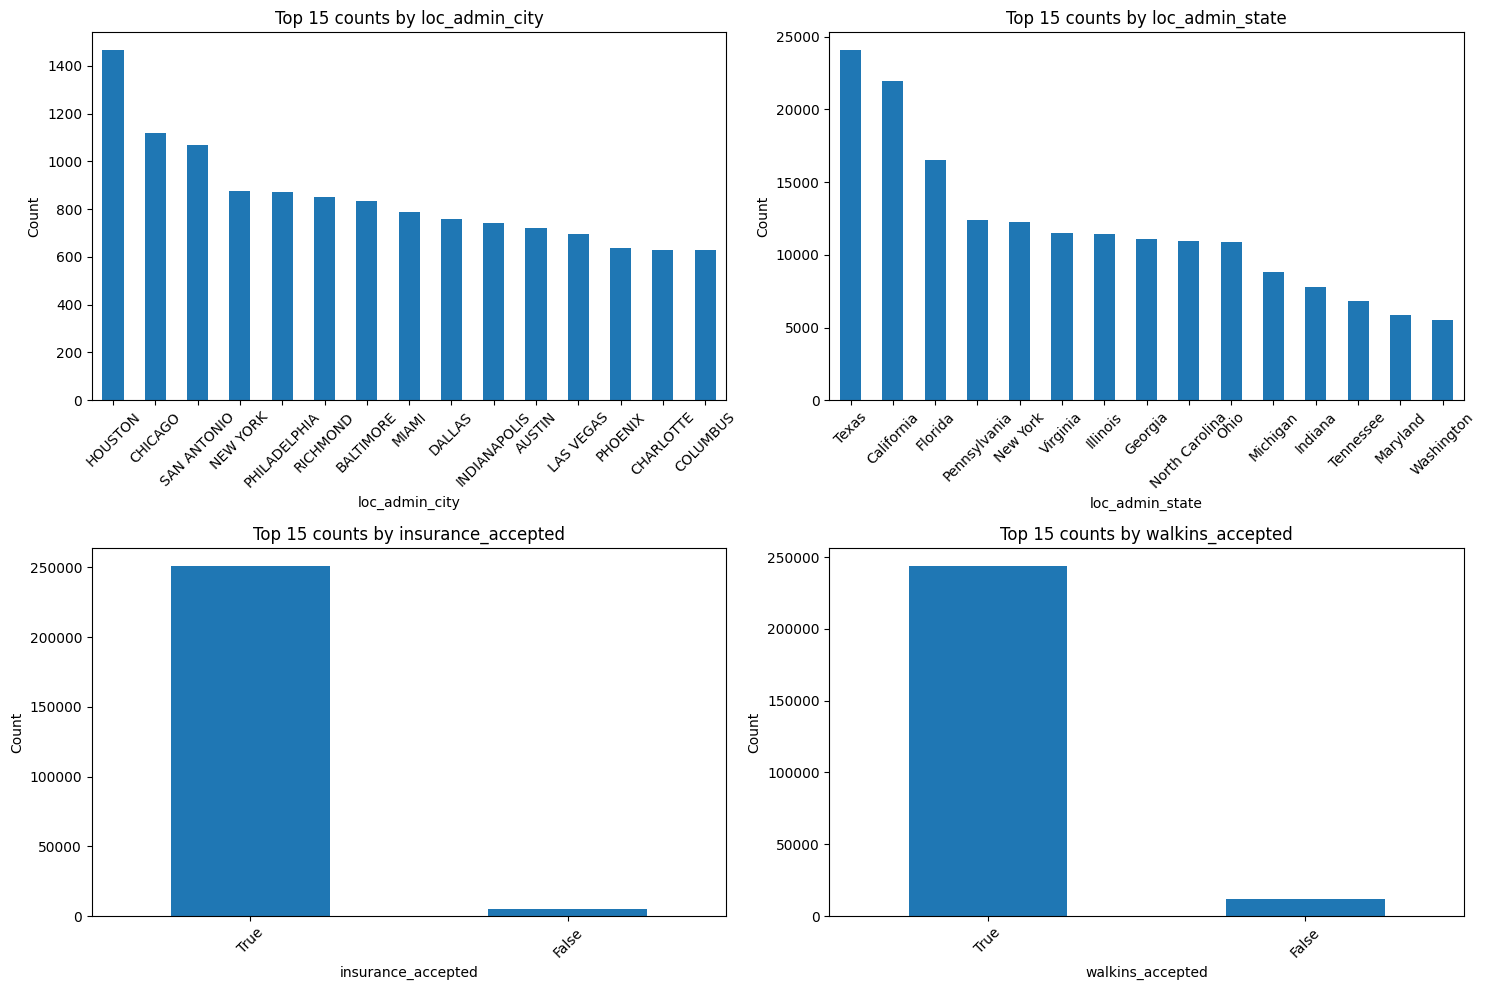

In [3]:
# Set of bar charts for all numeric columns
top_n = 15
columns = ['loc_admin_city', 'loc_admin_state', 'insurance_accepted', 'walkins_accepted']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns):
    df[col].value_counts().nlargest(top_n).plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Top {top_n} counts by {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## State Vaccination Count DF

In [4]:
#Creating dataframe for state calculations
coverage_cols = [
    'state_coverage', 's.13_17_years', 's.18_49_years', 's.18_49_years_at_high_risk',
    's.18_49_years_not_at_high_risk', 's.18_64_years', 's.18_64_years_at_high_risk',
    's.18_64_years_not_at_high_risk', 's.5_12_years', 's.50_64_years', 's.6_months___17_years',
    's.6_months___4_years', 's.black_non_hispanic', 's.greater_65', 's.greater_than_18_years_flu',
    's.greater_than_6_months_flu', 's.hispanic', 's.other_or_multiple_races_non_hispanic',
    's.white_non_hispanic'
]

state_vacc_count_df = df.groupby('loc_admin_state').agg(
    location_count = ('loc_admin_state', 'size'),
    **{col: (col, 'first') for col in coverage_cols}
).reset_index()
state_vacc_count_df = state_vacc_count_df.rename(
    columns={col: col.replace("s.", "") for col in state_vacc_count_df.columns}
)

state_vacc_count_df

,loc_admin_state,location_count,state_coverage,13_17_years,18_49_years,18_49_years_at_high_risk,18_49_years_not_at_high_risk,18_64_years,18_64_years_at_high_risk,18_64_years_not_at_high_risk,...,50_64_years,6_months___17_years,6_months___4_years,black_non_hispanic,greater_65,greater_than_18_years_flu,greater_than_6_months_flu,hispanic,other_or_multiple_races_non_hispanic,white_non_hispanic
0,Alabama,4567,33.233333,38.2,22.6,26.6,21.8,26.0,31.5,24.1,...,33.7,39.9,37.5,34.5,52.1,32.4,34.0,36.2,30.6,34.2
1,Alaska,666,36.905556,34.6,28.9,44.9,25.4,31.3,44.5,27.2,...,37.0,39.6,46.9,36.5,50.6,35.1,36.2,31.5,35.7,37.4
2,Arizona,5446,36.000000,38.0,17.8,32.2,16.0,23.2,39.2,19.4,...,34.9,45.7,54.9,33.5,60.0,34.2,38.6,36.5,35.5,41.3
3,Arkansas,2210,35.194444,37.4,23.3,22.1,24.0,27.9,31.2,26.9,...,37.5,44.1,43.7,34.0,56.9,35.3,37.3,35.1,27.2,39.3
4,California,21939,39.983333,47.2,27.4,29.5,26.9,30.3,36.0,28.5,...,36.9,53.6,60.5,32.0,56.1,36.1,39.9,33.0,44.2,47.5
5,Colorado,5280,43.255556,48.0,30.1,31.0,30.0,35.0,40.6,33.5,...,47.0,55.1,63.9,38.2,63.3,41.0,43.9,34.2,41.0,48.3
6,Connecticut,1011,48.594444,55.8,34.8,38.7,34.4,38.5,42.9,37.5,...,45.6,67.1,79.6,37.7,63.8,44.8,49.3,37.7,42.2,55.1
7,Delaware,995,40.788889,45.4,27.0,30.3,26.2,31.7,34.2,30.9,...,40.1,52.6,62.0,35.4,63.9,41.2,43.5,30.9,34.1,50.2
8,Florida,16555,31.972222,32.6,21.5,23.3,21.4,24.5,31.4,22.5,...,30.6,36.9,39.9,28.6,56.1,33.7,34.3,30.5,30.8,38.9
9,Georgia,11081,33.150000,32.5,21.2,26.5,20.2,25.7,35.2,22.6,...,35.8,40.9,46.9,31.3,52.5,31.4,33.6,27.4,33.4,36.6


In [5]:
# State population data
state_populations = {
    'Alabama': 5108468,
    'Alaska': 733391,
    'Arizona': 7431344,
    'Arkansas': 3067732,
    'California': 38965193,
    'Colorado': 5877610,
    'Connecticut': 3617176,
    'Delaware': 1031890,
    'Florida': 23244842,
    'Georgia': 11145304,
    'Hawaii': 1435138,
    'Idaho': 1983637,
    'Illinois': 12549689,
    'Indiana': 6862199,
    'Iowa': 3207004,
    'Kansas': 2940546,
    'Kentucky': 4555777,
    'Louisiana': 4573749,
    'Maine': 1407006,
    'Maryland': 6164660,
    'Massachusetts': 7001399,
    'Michigan': 10037261,
    'Minnesota': 5759644,
    'Mississippi': 2940057,
    'Missouri': 6196367,
    'Montana': 1123989,
    'Nebraska': 1978379,
    'Nevada': 3194176,
    'New Hampshire': 1407006,
    'New Jersey': 9290841,
    'New Mexico': 2114371,
    'New York': 19336776,
    'North Carolina': 10835491,
    'North Dakota': 811044,
    'Ohio': 11785935,
    'Oklahoma': 4053824,
    'Oregon': 4233358,
    'Pennsylvania': 12972008,
    'Rhode Island': 1110822,
    'South Carolina': 5464570,
    'South Dakota': 908414,
    'Tennessee': 7126489,
    'Texas': 31398676,
    'Utah': 3454226,
    'Vermont': 647464,
    'Virginia': 8715698,
    'Washington': 7888151,
    'West Virginia': 1770071,
    'Wisconsin': 5910955,
    'Wyoming': 584057
}

state_vacc_count_df['population'] = state_vacc_count_df['loc_admin_state'].map(state_populations)
state_vacc_count_df['locations_per_1000'] = (state_vacc_count_df['location_count'] / state_vacc_count_df['population']) * 1000

## State Vaccination Rate Population Hypothesis Test

Analyzing 19 coverage metrics across 50 states

SIGNIFICANT RELATIONSHIPS (p < 0.05)
Coverage Metric                          | Correlation |  P-value  | N States
----------------------------------------|-------------|-----------|----------
5_12_years                              |   -0.3499   |  0.012736 |       50
18_64_years_at_high_risk                |   -0.3407   |  0.015483 |       50
6_months___17_years                     |   -0.3211   |  0.022979 |       50
18_49_years_at_high_risk                |   -0.3142   |  0.026275 |       50
6_months___4_years                      |   -0.3051   |  0.031201 |       50
state_coverage                          |   -0.2841   |  0.045585 |       50
13_17_years                             |   -0.2809   |  0.048133 |       50


NON-SIGNIFICANT RELATIONSHIPS (p >= 0.05)
Coverage Metric                          | Correlation |  P-value  | N States
----------------------------------------|-------------|-----------|----------
18_49_years         

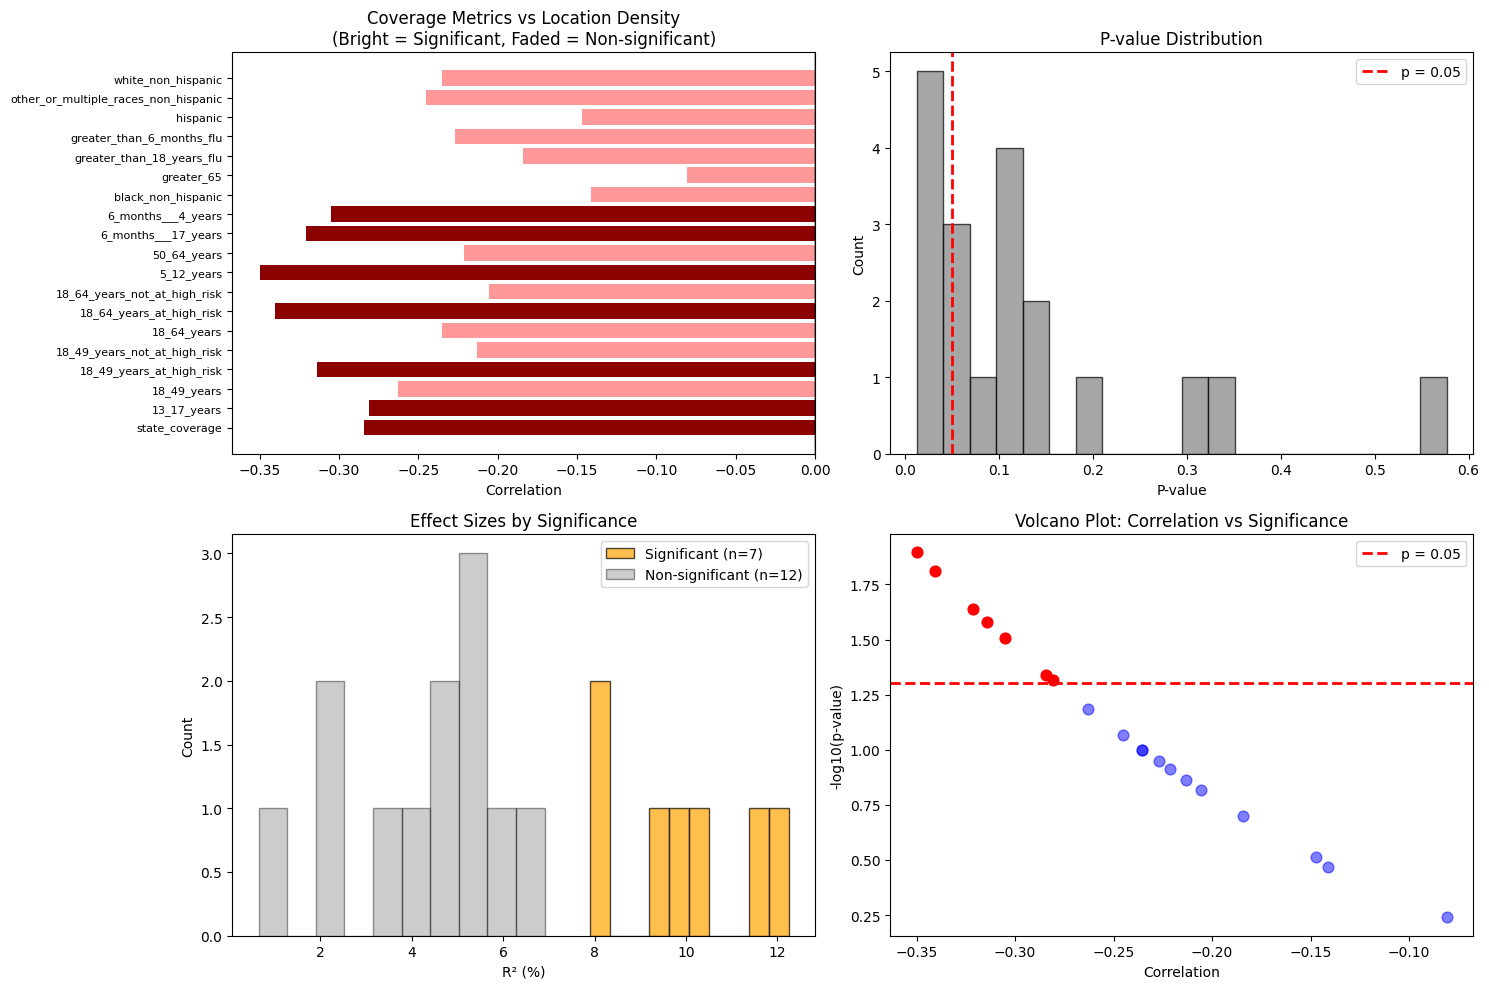


Final Results: 7 of 19 metrics show significant correlation with location density


In [6]:
# State Analysis: Coverage Metrics vs Location Density

exclude_cols = ['loc_admin_state', 'location_count', 'population', 'locations_per_1000']
coverage_columns = [col for col in state_vacc_count_df.columns if col not in exclude_cols]

print(f"Analyzing {len(coverage_columns)} coverage metrics across {len(state_vacc_count_df)} states\n")

results = []
locations_per_1000 = state_vacc_count_df['locations_per_1000']

for col in coverage_columns:
    coverage_data = state_vacc_count_df[col]
    
    # Check if column is numeric, skip if not
    if not pd.api.types.is_numeric_dtype(coverage_data):
        print(f"Skipping non-numeric column: {col}")
        continue
    
    # Convert to numeric if needed, coercing errors to NaN
    coverage_data = pd.to_numeric(coverage_data, errors='coerce')
    valid_data = ~(locations_per_1000.isna() | coverage_data.isna())
    
    if valid_data.sum() < 10:
        print(f"Skipping {col}: insufficient data ({valid_data.sum()} valid observations)")
        continue
    
    r, p = pearsonr(locations_per_1000[valid_data], coverage_data[valid_data])
    
    results.append({
        'metric': col,
        'correlation': r,
        'p_value': p,
        'significant': p < 0.05,
        'n_states': valid_data.sum()
    })

results_df = pd.DataFrame(results)

# Separate significant and non-significant results
significant_results = results_df[results_df['significant']].sort_values('correlation', key=abs, ascending=False)
non_significant_results = results_df[~results_df['significant']].sort_values('correlation', key=abs, ascending=False)

# Display significant relationships
print("SIGNIFICANT RELATIONSHIPS (p < 0.05)")
print("Coverage Metric                          | Correlation |  P-value  | N States")
print("----------------------------------------|-------------|-----------|----------")
for _, row in significant_results.iterrows():
    print(f"{row['metric']:39s} |   {row['correlation']:7.4f}   | {row['p_value']:9.6f} | {row['n_states']:8d}")

print("\n" + "="*80 + "\n")

# Display non-significant relationships
print("NON-SIGNIFICANT RELATIONSHIPS (p >= 0.05)")
print("Coverage Metric                          | Correlation |  P-value  | N States")
print("----------------------------------------|-------------|-----------|----------")
for _, row in non_significant_results.iterrows():
    print(f"{row['metric']:39s} |   {row['correlation']:7.4f}   | {row['p_value']:9.6f} | {row['n_states']:8d}")

# Summary stats
if len(results_df) > 0:
    print(f"\nSUMMARY:")
    print(f"Total metrics analyzed: {len(results_df)}")
    print(f"Significant correlations: {results_df['significant'].sum()}/{len(results_df)}")
    print(f"Mean correlation: {results_df['correlation'].mean():.4f}")
    
    # Top correlations from significant results
    if len(significant_results) > 0:
        print("\nStrongest significant positive correlations:")
        top_positive_sig = significant_results[significant_results['correlation'] > 0].nlargest(3, 'correlation')
        for _, row in top_positive_sig.iterrows():
            print(f"  {row['metric']:35s}: r = {row['correlation']:6.3f}*")
        
        print("\nStrongest significant negative correlations:")
        top_negative_sig = significant_results[significant_results['correlation'] < 0].nsmallest(3, 'correlation')
        for _, row in top_negative_sig.iterrows():
            print(f"  {row['metric']:35s}: r = {row['correlation']:6.3f}*")
    
    # Top correlations from non-significant results
    if len(non_significant_results) > 0:
        print("\nStrongest non-significant correlations:")
        top_nonsig = non_significant_results.head(3)
        for _, row in top_nonsig.iterrows():
            print(f"  {row['metric']:35s}: r = {row['correlation']:6.3f}")

# Visualization
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Correlation plot - separate significant and non-significant
    correlations = results_df['correlation'].values
    colors = ['darkred' if (r < 0 and results_df.iloc[i]['significant']) else 
              'red' if (r < 0 and not results_df.iloc[i]['significant']) else
              'darkblue' if (r > 0 and results_df.iloc[i]['significant']) else 
              'blue' for i, r in enumerate(correlations)]
    sig_alpha = [1.0 if results_df.iloc[i]['significant'] else 0.4 for i in range(len(correlations))]
    
    y_pos = np.arange(len(correlations))
    bars = axes[0,0].barh(y_pos, correlations, color=colors)
    
    for bar, alpha in zip(bars, sig_alpha):
        bar.set_alpha(alpha)
    
    axes[0,0].set_yticks(y_pos[::max(1, len(y_pos)//15)])
    axes[0,0].set_yticklabels([results_df.iloc[i]['metric'] for i in y_pos[::max(1, len(y_pos)//15)]], 
                              fontsize=8)
    axes[0,0].set_xlabel('Correlation')
    axes[0,0].set_title('Coverage Metrics vs Location Density\n(Bright = Significant, Faded = Non-significant)')
    axes[0,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # P-value histogram with significance line
    axes[0,1].hist(results_df['p_value'], bins=20, alpha=0.7, color='gray', edgecolor='black')
    axes[0,1].axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='p = 0.05')
    axes[0,1].set_xlabel('P-value')
    axes[0,1].set_ylabel('Count')
    axes[0,1].set_title('P-value Distribution')
    axes[0,1].legend()
    
    # Effect size histogram - separate significant and non-significant
    sig_effect_sizes = (significant_results['correlation'] ** 2) * 100
    nonsig_effect_sizes = (non_significant_results['correlation'] ** 2) * 100
    
    if len(sig_effect_sizes) > 0:
        axes[1,0].hist(sig_effect_sizes, bins=10, alpha=0.7, color='orange', 
                       label=f'Significant (n={len(sig_effect_sizes)})', edgecolor='black')
    if len(nonsig_effect_sizes) > 0:
        axes[1,0].hist(nonsig_effect_sizes, bins=10, alpha=0.4, color='gray', 
                       label=f'Non-significant (n={len(nonsig_effect_sizes)})', edgecolor='black')
    
    axes[1,0].set_xlabel('R² (%)')
    axes[1,0].set_ylabel('Count')
    axes[1,0].set_title('Effect Sizes by Significance')
    axes[1,0].legend()
    
    # Volcano plot: Correlation vs significance
    scatter_colors = ['red' if s else 'blue' for s in results_df['significant']]
    scatter_alpha = [1.0 if s else 0.5 for s in results_df['significant']]
    
    for i, (corr, pval, sig) in enumerate(zip(correlations, results_df['p_value'], results_df['significant'])):
        axes[1,1].scatter(corr, -np.log10(pval), c=scatter_colors[i], alpha=scatter_alpha[i], s=60)
    
    axes[1,1].axhline(y=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p = 0.05')
    axes[1,1].set_xlabel('Correlation')
    axes[1,1].set_ylabel('-log10(p-value)')
    axes[1,1].set_title('Volcano Plot: Correlation vs Significance')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    sig_count = results_df['significant'].sum()
    print(f"\nFinal Results: {sig_count} of {len(results_df)} metrics show significant correlation with location density")

# Counties Df

In [7]:
county_df = pd.read_csv("data/avg_county_coverage.csv")

## County Vaccination Rate Population Hypothesis Test

Sample size: 2,602 counties

Coverage Metric              | Correlation | P-value | Significant?
----------------------------|-------------|---------|-------------
Overall Coverage            |     0.042   |  0.0305 |     Yes
Adult Coverage (≥18)        |     0.034   |  0.0808 |     No 
Non-Medical Setting         |     0.046   |  0.0190 |     Yes

Effect sizes: Overall: 0.2%, Adult: 0.1%, Non-Medical: 0.2%

Coverage metric correlations:
Overall vs Adult: r = 0.937, p = 0.0000
Overall vs Non-Medical: r = 0.669, p = 0.0000
Adult vs Non-Medical: r = 0.367, p = 0.0000


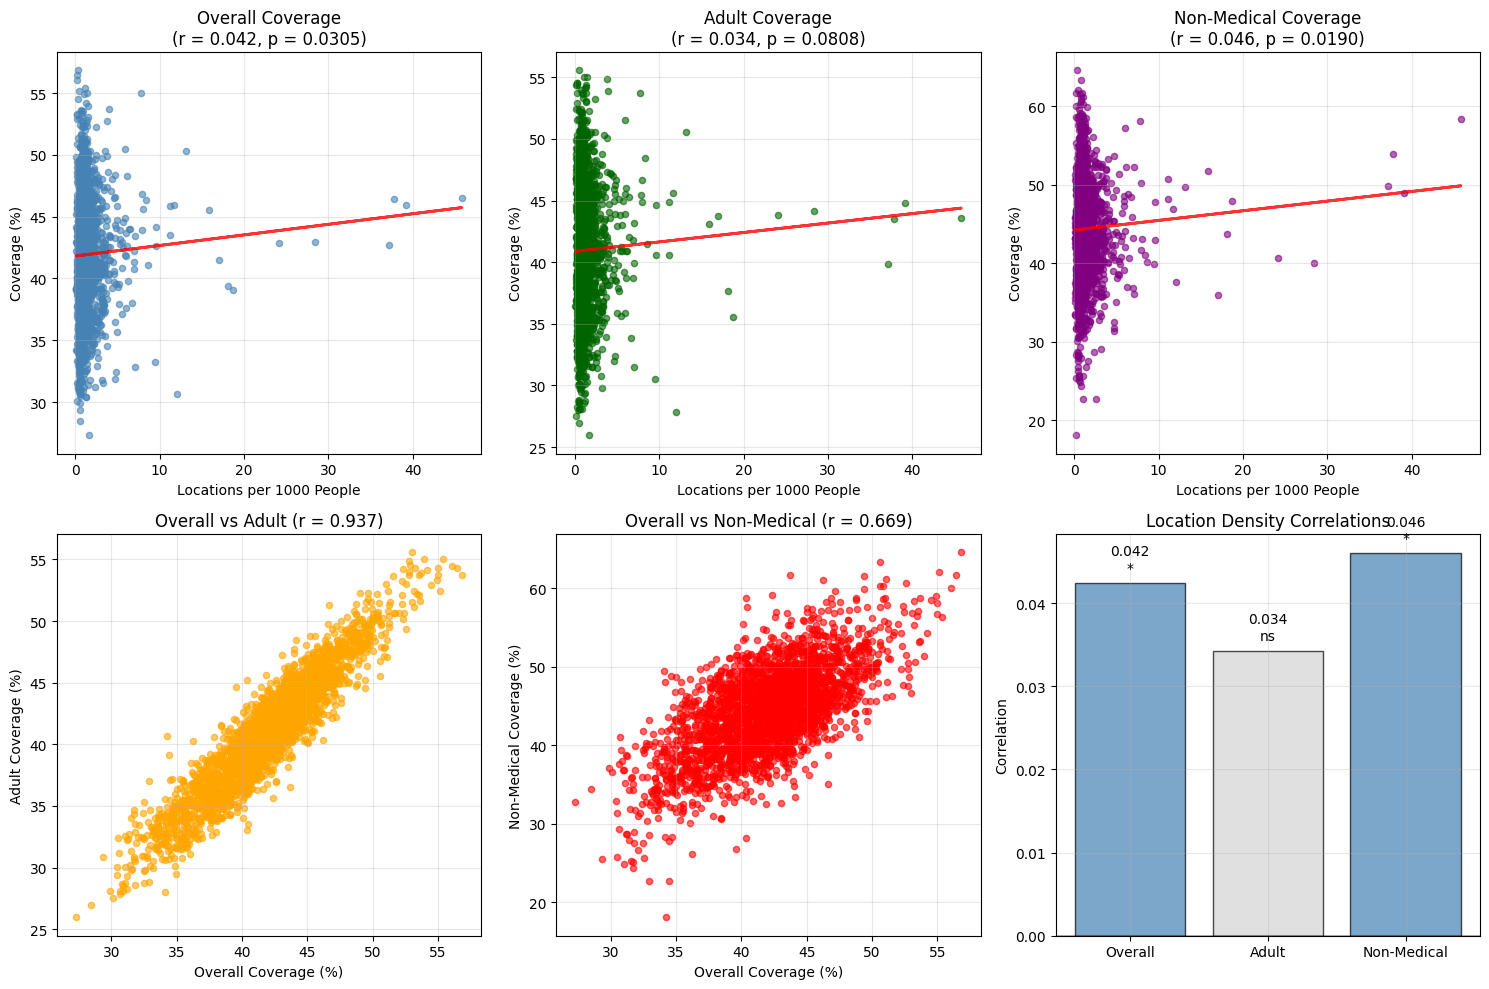


Results: 2 of 3 coverage metrics show significant correlation with location density


In [8]:
locations_per_1000 = county_df['location_per_1000']
overall_coverage = county_df['coverage_estimate'] 
adult_coverage = county_df['>=18 Years']
nonmedical_coverage = county_df['Non-Medical Setting']

complete_data = ~(locations_per_1000.isna() | overall_coverage.isna() | 
                  adult_coverage.isna() | nonmedical_coverage.isna())
n_complete = complete_data.sum()

print(f"Sample size: {n_complete:,} counties\n")

print("Coverage Metric              | Correlation | P-value | Significant?")
print("----------------------------|-------------|---------|-------------")

r1, p1 = pearsonr(locations_per_1000[complete_data], overall_coverage[complete_data])
print(f"Overall Coverage            |    {r1:6.3f}   | {p1:7.4f} |     {'Yes' if p1<0.05 else 'No':3s}")
r2, p2 = pearsonr(locations_per_1000[complete_data], adult_coverage[complete_data])
print(f"Adult Coverage (≥18)        |    {r2:6.3f}   | {p2:7.4f} |     {'Yes' if p2<0.05 else 'No':3s}")
r3, p3 = pearsonr(locations_per_1000[complete_data], nonmedical_coverage[complete_data])
print(f"Non-Medical Setting         |    {r3:6.3f}   | {p3:7.4f} |     {'Yes' if p3<0.05 else 'No':3s}")
print(f"\nEffect sizes: Overall: {r1**2*100:.1f}%, Adult: {r2**2*100:.1f}%, Non-Medical: {r3**2*100:.1f}%")

print("\nCoverage metric correlations:")
r_oa, p_oa = pearsonr(overall_coverage[complete_data], adult_coverage[complete_data])
r_on, p_on = pearsonr(overall_coverage[complete_data], nonmedical_coverage[complete_data])
r_an, p_an = pearsonr(adult_coverage[complete_data], nonmedical_coverage[complete_data])

print(f"Overall vs Adult: r = {r_oa:.3f}, p = {p_oa:.4f}")
print(f"Overall vs Non-Medical: r = {r_on:.3f}, p = {p_on:.4f}")
print(f"Adult vs Non-Medical: r = {r_an:.3f}, p = {p_an:.4f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
coverage_data = [
    (overall_coverage, 'Overall Coverage', 'steelblue', r1, p1),
    (adult_coverage, 'Adult Coverage', 'darkgreen', r2, p2),
    (nonmedical_coverage, 'Non-Medical Coverage', 'purple', r3, p3)
]

for i, (coverage, title, color, r, p) in enumerate(coverage_data):
    axes[0,i].scatter(locations_per_1000[complete_data], coverage[complete_data], 
                      alpha=0.6, s=20, color=color)
    z = np.polyfit(locations_per_1000[complete_data], coverage[complete_data], 1)
    p_line = np.poly1d(z)
    axes[0,i].plot(locations_per_1000[complete_data], p_line(locations_per_1000[complete_data]), 
                   "r-", alpha=0.8, linewidth=2)
    axes[0,i].set_xlabel('Locations per 1000 People')
    axes[0,i].set_ylabel('Coverage (%)')
    axes[0,i].set_title(f'{title}\n(r = {r:.3f}, p = {p:.4f})')
    axes[0,i].grid(True, alpha=0.3)

axes[1,0].scatter(overall_coverage[complete_data], adult_coverage[complete_data], 
                  alpha=0.6, s=20, color='orange')
axes[1,0].set_xlabel('Overall Coverage (%)')
axes[1,0].set_ylabel('Adult Coverage (%)')
axes[1,0].set_title(f'Overall vs Adult (r = {r_oa:.3f})')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].scatter(overall_coverage[complete_data], nonmedical_coverage[complete_data], 
                  alpha=0.6, s=20, color='red')
axes[1,1].set_xlabel('Overall Coverage (%)')
axes[1,1].set_ylabel('Non-Medical Coverage (%)')
axes[1,1].set_title(f'Overall vs Non-Medical (r = {r_on:.3f})')
axes[1,1].grid(True, alpha=0.3)

# Summary bar chart
metrics = ['Overall', 'Adult', 'Non-Medical']
correlations = [r1, r2, r3]
p_values = [p1, p2, p3]

colors = ['steelblue' if p < 0.05 else 'lightgray' for p in p_values]
bars = axes[1,2].bar(metrics, correlations, color=colors, alpha=0.7, edgecolor='black')

for i, (bar, p_val) in enumerate(zip(bars, p_values)):
    height = bar.get_height()
    sig_marker = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
    axes[1,2].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{correlations[i]:.3f}\n{sig_marker}',
                   ha='center', va='bottom', fontsize=10)

axes[1,2].set_ylabel('Correlation')
axes[1,2].set_title('Location Density Correlations')
axes[1,2].grid(True, alpha=0.3)
axes[1,2].axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

significant_tests = sum([p1 < 0.05, p2 < 0.05, p3 < 0.05])
print(f"\nResults: {significant_tests} of 3 coverage metrics show significant correlation with location density")

# State Area Analysis

In [9]:
#State Area in square miles
state_area = {
    "Alabama": 52420,
    "Alaska": 665384,
    "Arizona": 113990,
    "Arkansas": 53179,
    "California": 163695,
    "Colorado": 104094,
    "Connecticut": 5543,
    "Delaware": 2489,
    "Florida": 65758,
    "Georgia": 59425,
    "Hawaii": 10932,
    "Idaho": 83569,
    "Illinois": 57914,
    "Indiana": 36420,
    "Iowa": 56273,
    "Kansas": 82278,
    "Kentucky": 40408,
    "Louisiana": 52378,
    "Maine": 35380,
    "Maryland": 12406,
    "Massachusetts": 10554,
    "Michigan": 96714,
    "Minnesota": 86936,
    "Mississippi": 48432,
    "Missouri": 69707,
    "Montana": 147040,
    "Nebraska": 77348,
    "Nevada": 110572,
    "New Hampshire": 9349,
    "New Jersey": 8723,
    "New Mexico": 121590,
    "New York": 54555,
    "North Carolina": 53819,
    "North Dakota": 70698,
    "Ohio": 44826,
    "Oklahoma": 69899,
    "Oregon": 98379,
    "Pennsylvania": 46054,
    "Rhode Island": 1545,
    "South Carolina": 32020,
    "South Dakota": 77116,
    "Tennessee": 42144,
    "Texas": 268596,
    "Utah": 84897,
    "Vermont": 9616,
    "Virginia": 42775,
    "Washington": 71298,
    "West Virginia": 24230,
    "Wisconsin": 65496,
    "Wyoming": 97813
}

In [10]:
# Merging state area into DataFrame
area_df = pd.DataFrame(list(state_area.items()), columns=['State', 'Area'])
state_vacc_count_df = state_vacc_count_df.merge(area_df, left_on='loc_admin_state', right_on='State')
# Locations per square mile
state_vacc_count_df['locations_per_sq_mile'] = state_vacc_count_df['location_count'] / state_vacc_count_df['Area']

# Run Pearson correlation analysis using locations_per_sq_mile
exclude_cols = ['loc_admin_state', 'location_count', 'population', 'locations_per_1000', 'State', 'Area']
coverage_columns = [col for col in state_vacc_count_df.columns if col not in exclude_cols]
print(f"Analyzing {len(coverage_columns)} coverage metrics across {len(state_vacc_count_df)} states\n")

results = []
locations_density = state_vacc_count_df['locations_per_sq_mile']

for col in coverage_columns:
    coverage_data = state_vacc_count_df[col]
    valid_data = ~(locations_density.isna() | coverage_data.isna())
    
    if valid_data.sum() < 10:
        continue
    
    r, p = pearsonr(locations_density[valid_data], coverage_data[valid_data])
    
    results.append({
        'metric': col,
        'correlation': r,
        'p_value': p,
        'significant': p < 0.05,
        'n_states': valid_data.sum()
    })

results_df = pd.DataFrame(results)

# Separate significant and non-significant results
significant_results = results_df[results_df['significant']].sort_values('correlation', key=abs, ascending=False)
non_significant_results = results_df[~results_df['significant']].sort_values('correlation', key=abs, ascending=False)

# Display significant relationships
print("SIGNIFICANT RELATIONSHIPS (p < 0.05)")
print("Coverage Metric                          | Correlation |  P-value  | N States")
print("----------------------------------------|-------------|-----------|----------")
for _, row in significant_results.iterrows():
    print(f"{row['metric']:39s} |   {row['correlation']:7.4f}   | {row['p_value']:9.6f} | {row['n_states']:8d}")

print("\n" + "="*80 + "\n")

# Display non-significant relationships
print("NON-SIGNIFICANT RELATIONSHIPS (p >= 0.05)")
print("Coverage Metric                          | Correlation |  P-value  | N States")
print("----------------------------------------|-------------|-----------|----------")
for _, row in non_significant_results.iterrows():
    print(f"{row['metric']:39s} |   {row['correlation']:7.4f}   | {row['p_value']:9.6f} | {row['n_states']:8d}")

print(f"\nSUMMARY:")
print(f"Total metrics analyzed: {len(results_df)}")
print(f"Significant relationships: {len(significant_results)}")
print(f"Non-significant relationships: {len(non_significant_results)}")
if len(significant_results) > 0:
    print(f"Strongest significant correlation: {significant_results.iloc[0]['correlation']:.4f} ({significant_results.iloc[0]['metric']})")
if len(non_significant_results) > 0:
    print(f"Strongest non-significant correlation: {non_significant_results.iloc[0]['correlation']:.4f} ({non_significant_results.iloc[0]['metric']})")

Analyzing 20 coverage metrics across 50 states

SIGNIFICANT RELATIONSHIPS (p < 0.05)
Coverage Metric                          | Correlation |  P-value  | N States
----------------------------------------|-------------|-----------|----------
locations_per_sq_mile                   |    1.0000   |  0.000000 |       50
white_non_hispanic                      |    0.4672   |  0.000624 |       50
6_months___17_years                     |    0.4096   |  0.003139 |       50
13_17_years                             |    0.4038   |  0.003633 |       50
5_12_years                              |    0.3995   |  0.004047 |       50
greater_than_6_months_flu               |    0.3334   |  0.017984 |       50
greater_65                              |    0.3290   |  0.019650 |       50
6_months___4_years                      |    0.3276   |  0.020230 |       50
state_coverage                          |    0.3087   |  0.029169 |       50
greater_than_18_years_flu               |    0.2839   |  0.045738 

# County Area Analysis

In [11]:
locations_per_sqmile = county_df['locations_per_sq_mile']

# Coverage metrics
overall_coverage = county_df['coverage_estimate'] 
adult_coverage = county_df['>=18 Years']
nonmedical_coverage = county_df['Non-Medical Setting']

# Filter out missing data
complete_data = ~(locations_per_sqmile.isna() | overall_coverage.isna() | 
                  adult_coverage.isna() | nonmedical_coverage.isna())
n_complete = complete_data.sum()

print(f"Sample size: {n_complete:,} counties\n")
print("Coverage Metric              | Correlation | P-value | Significant?")
print("----------------------------|-------------|---------|-------------")

results = []
for name, coverage in zip(
    ['Overall Coverage', 'Adult Coverage (≥18)', 'Non-Medical Setting'],
    [overall_coverage, adult_coverage, nonmedical_coverage]
):
    r, p = pearsonr(locations_per_sqmile[complete_data], coverage[complete_data])
    sig = 'Yes' if p < 0.05 else 'No'
    print(f"{name:28s} | {r:11.3f} | {p:7.4f} | {sig:11s}")
    results.append((name, r, p, sig))

effect_sizes = [(name, r**2*100) for name, r, _, _ in results]
print("\nEffect sizes:")
for name, es in effect_sizes:
    print(f"{name:28s}: {es:.1f}%")

Sample size: 2,602 counties

Coverage Metric              | Correlation | P-value | Significant?
----------------------------|-------------|---------|-------------
Overall Coverage             |       0.130 |  0.0000 | Yes        
Adult Coverage (≥18)         |       0.118 |  0.0000 | Yes        
Non-Medical Setting          |       0.097 |  0.0000 | Yes        

Effect sizes:
Overall Coverage            : 1.7%
Adult Coverage (≥18)        : 1.4%
Non-Medical Setting         : 0.9%


In [12]:
county_df = county_df.sort_values(by="locations_per_sq_mile", ascending=False)
county_df

,state,county_name,population,state_fips,county_fips,GEOID,location_count,coverage_estimate,>=18 Years,Non-Medical Setting,area_sqmiles,NAME,locations_per_sq_mile,location_per_1000
2412,Virginia,Falls Church,14576.0,51,610,51610,113,55.000000,53.76,58.10,3.368504,Falls Church,33.546044,7.752470
1542,New York,New York,1645867.0,36,61,36061,937,46.514286,47.12,45.00,58.871673,New York,15.915974,0.569305
2411,Virginia,Fairfax,24242.0,51,600,51600,144,50.471429,51.50,47.90,10.317026,Fairfax,13.957510,5.940104
2422,Virginia,Manassas Park,17123.0,51,685,51685,52,40.328571,39.38,42.70,4.978873,Manassas Park,10.444131,3.036851
2414,Virginia,Fredericksburg,28258.0,51,630,51630,151,43.928571,40.94,51.40,17.035965,Fredericksburg,8.863601,5.343620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,Alaska,Dillingham,4854.0,2,70,2070,4,31.728571,34.70,24.30,80744.332637,Dillingham,0.000050,0.824063
85,Alaska,Southeast Fairbanks,6888.0,2,240,2240,6,30.900000,28.06,38.00,128997.810992,Southeast Fairbanks,0.000047,0.871080
80,Alaska,Northwest Arctic,7682.0,2,188,2188,4,29.328571,30.84,25.55,265018.004406,Northwest Arctic,0.000015,0.520698
79,Alaska,North Slope,10924.0,2,185,2185,5,32.771429,33.72,30.40,760079.531877,North Slope,0.000007,0.457708
